In [1]:
import tensorflow as tf

# GPU Memory Growth
gpus = tf.config.list_physical_devices('GPU')
for gpu in gpus:
    tf.config.experimental.set_memory_growth(gpu, True)




In [2]:
import tensorflow as tf
print("GPU Available:", tf.test.is_gpu_available())
print(tf.config.list_physical_devices('GPU'))


Instructions for updating:
Use `tf.config.list_physical_devices('GPU')` instead.
GPU Available: True
[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [3]:
import os
import cv2
import numpy as np
from tensorflow.keras.preprocessing.image import ImageDataGenerator # type: ignore
from tensorflow.keras.applications import EfficientNetB7 # type: ignore
from tensorflow.keras.models import Sequential # type: ignore
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout, BatchNormalization, Flatten, MaxPooling2D, Conv2D # type: ignore
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay, accuracy_score
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm


In [7]:
def extract_frames(video_path, output_folder, every_n_frame=10):
    os.makedirs(output_folder, exist_ok=True)
    cap = cv2.VideoCapture(video_path)
    frame_count = 0
    success, frame = cap.read()
    while success:
        if frame_count % every_n_frame == 0:
            frame_name = f"frame_{frame_count}.jpg"
            cv2.imwrite(os.path.join(output_folder, frame_name), frame)
        success, frame = cap.read()
        frame_count += 1
    cap.release()


In [8]:
def process_videos(input_dir, output_base_dir, label, num_videos=100, num_frames=10):
    video_files = [f for f in os.listdir(input_dir) if f.lower().endswith(('.mp4', '.avi', '.mov', '.mkv'))]
    output_dir = os.path.join(output_base_dir, label)
    os.makedirs(output_dir, exist_ok=True)
    
    for video_name in tqdm(video_files[:num_videos], desc=f"Extracting {label} frames"):
        video_path = os.path.join(input_dir, video_name)
        video_output_dir = os.path.join(output_dir, os.path.splitext(video_name)[0])
        extract_frames(video_path, video_output_dir, every_n_frame=num_frames)


In [6]:
base_path = r"D:\DeepFake_detector\data"
fake_videos_path = os.path.join(base_path, 'fake')
real_videos_path = os.path.join(base_path, 'real')

In [10]:
output_base_dir = os.path.join(base_path, r'D:\DeepFake_detector\extracted_frames')

# استخراج الفريمات
process_videos(fake_videos_path, output_base_dir, label='fake', num_videos=100)
process_videos(real_videos_path, output_base_dir, label='real', num_videos=100)

Extracting real frames: 100%|██████████| 100/100 [07:28<00:00,  4.49s/it]


In [8]:
def preprocess_frames(input_dir, output_dir, img_size=(128, 128)):
    os.makedirs(output_dir, exist_ok=True)

    for label in ['real', 'fake']:
        label_dir = os.path.join(input_dir, label)
        output_label_dir = os.path.join(output_dir, label)
        os.makedirs(output_label_dir, exist_ok=True)

        video_folders = os.listdir(label_dir)

        for video_folder in tqdm(video_folders, desc=f"Processing {label} videos"):
            frames_folder = os.path.join(label_dir, video_folder)
            if not os.path.isdir(frames_folder):
                continue

            output_video_dir = os.path.join(output_label_dir, video_folder)
            os.makedirs(output_video_dir, exist_ok=True)

            for frame_name in os.listdir(frames_folder):
                frame_path = os.path.join(frames_folder, frame_name)
                img = cv2.imread(frame_path)
                if img is None:
                    continue
                img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
                img = cv2.resize(img, img_size)
                img = img / 255.0  # Normalize
                np.save(os.path.join(output_video_dir, frame_name.replace('.jpg', '.npy')), img)


In [ ]:
input_dir = r'D:\DeepFake_detector\extracted_frames'
output_dir = r'D:\DeepFake_detector\preprocessed_frames'

preprocess_frames(input_dir, output_dir)


Processing fake videos: 100%|██████████| 100/100 [02:23<00:00,  1.44s/it]


In [4]:
def load_preprocessed_data(base_dir):
    X = []
    y = []

    for label in ['real', 'fake']:
        label_dir = os.path.join(base_dir, label)
        label_value = 0 if label == 'real' else 1

        for video_folder in tqdm(os.listdir(label_dir), desc=f"Loading {label} data"):
            video_path = os.path.join(label_dir, video_folder)
            if not os.path.isdir(video_path):
                continue

            for frame_file in os.listdir(video_path):
                if frame_file.endswith('.npy'):
                    frame_path = os.path.join(video_path, frame_file)
                    frame = np.load(frame_path)
                    X.append(frame)
                    y.append(label_value)

    X = np.array(X)
    y = np.array(y)

    return X, y

In [5]:
# تحميل البيانات
data_dir = r'D:\DeepFake_detector\preprocessed_frames'
X, y = load_preprocessed_data(data_dir)

print(f"✅ Loaded data: {X.shape[0]} frames")
print(f"🧠 Data shape: {X.shape}")
print(f"🎯 Labels shape: {y.shape}")

Loading fake data: 100%|██████████| 100/100 [01:11<00:00,  1.40it/s]


✅ Loaded data: 14796 frames
🧠 Data shape: (14796, 128, 128, 3)
🎯 Labels shape: (14796,)


In [6]:
# تقسيم البيانات إلى تدريب واختبار
X_train, X_val, y_train, y_val = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

print(f"Training set: {X_train.shape}, Validation set: {X_val.shape}")

Training set: (11836, 128, 128, 3), Validation set: (2960, 128, 128, 3)


In [7]:
import numpy as np

def data_generator(X, y, batch_size=4):
    n = len(X)
    idx = np.arange(n)

    while True:
        np.random.shuffle(idx)
        for i in range(0, n, batch_size):
            batch_idx = idx[i:i+batch_size]
            yield X[batch_idx], y[batch_idx]


In [8]:
import tensorflow as tf

BATCH = 4

train_gen = lambda: data_generator(X_train, y_train, BATCH)
val_gen   = lambda: data_generator(X_val, y_val, BATCH)

train_ds = tf.data.Dataset.from_generator(
    train_gen,
    output_types=(tf.float32, tf.float32),
    output_shapes=((None, 128, 128, 3), (None,))
)

val_ds = tf.data.Dataset.from_generator(
    val_gen,
    output_types=(tf.float32, tf.float32),
    output_shapes=((None, 128, 128, 3), (None,))
)


In [9]:
train_ds = train_ds.prefetch(2)
val_ds   = val_ds.prefetch(2)


In [ ]:
from tensorflow.keras import layers, models

IMG_SIZE = (128, 128, 3)

def build_model():
    base = tf.keras.applications.MobileNetV2(
        input_shape=IMG_SIZE,
        include_top=False,
        weights="imagenet"
    )

    base.trainable = True
    for layer in base.layers[:-40]:  # Fine tune last 40 layers
        layer.trainable = False

    inp = layers.Input(shape=IMG_SIZE)
    x = tf.keras.applications.mobilenet_v2.preprocess_input(inp)
    x = base(x, training=True)
    x = layers.GlobalAveragePooling2D()(x)
    x = layers.Dense(512, activation="relu")(x)
    x = layers.Dropout(0.3)(x)
    x = layers.Dense(256, activation="relu")(x)
    x = layers.Dropout(0.3)(x)
    x = layers.Dense(64, activation="relu")(x)
    x = layers.Dropout(0.3)(x)
    out = layers.Dense(1, activation="sigmoid", dtype="float32")(x)

    model = models.Model(inp, out)

    model.compile(
        optimizer=tf.keras.optimizers.Adam(1e-5),
        loss="binary_crossentropy",
        metrics=["accuracy"]
    )

    return model

model = build_model()
model.summary()


Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 128, 128, 3)]     0         
                                                                 
 tf.math.truediv (TFOpLambda  (None, 128, 128, 3)      0         
 )                                                               
                                                                 
 tf.math.subtract (TFOpLambd  (None, 128, 128, 3)      0         
 a)                                                              
                                                                 
 mobilenetv2_1.00_128 (Funct  (None, 4, 4, 1280)       2257984   
 ional)                                                          
                                                                 
 global_average_pooling2d (G  (None, 1280)             0         
 lobalAveragePooling2D)                                      

In [10]:
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau

callbacks_list = [
    ModelCheckpoint("best_model.keras", save_best_only=True, monitor="val_loss"),
    EarlyStopping(patience=4, restore_best_weights=True),
    ReduceLROnPlateau(factor=0.5, patience=2)
]


In [ ]:
history = model.fit(
    train_ds,
    validation_data=val_ds,
    steps_per_epoch=len(X_train)//BATCH,
    validation_steps=len(X_val)//BATCH,
    epochs=15,
    callbacks=callbacks_list
)


Epoch 1/3
2959/2959 [==============================] - 108s 33ms/step - loss: 0.2983 - accuracy: 0.8815 - val_loss: 0.3190 - val_accuracy: 0.8706 - lr: 1.0000e-05
Epoch 2/3
2959/2959 [==============================] - 100s 34ms/step - loss: 0.2978 - accuracy: 0.8820 - val_loss: 0.2659 - val_accuracy: 0.8980 - lr: 1.0000e-05
Epoch 3/3
2959/2959 [==============================] - 96s 32ms/step - loss: 0.2904 - accuracy: 0.8872 - val_loss: 0.2664 - val_accuracy: 0.8993 - lr: 1.0000e-05


In [ ]:
# # 🔧 إعداد البيانات (normalization + augmentation)
# train_datagen = ImageDataGenerator(
#     rescale=1./255,
#     rotation_range=10,
#     zoom_range=0.1,
#     horizontal_flip=True
# )

# val_datagen = ImageDataGenerator(rescale=1./255)

In [ ]:
# # ✅ بناء الموديل
# model = Sequential([
#     Conv2D(32, (3,3), activation='relu', input_shape=(128, 128, 3)),
#     BatchNormalization(),
#     MaxPooling2D(2,2),

#     Conv2D(64, (3,3), activation='relu'),
#     BatchNormalization(),
#     MaxPooling2D(2,2),

#     Conv2D(128, (3,3), activation='relu'),
#     BatchNormalization(),
#     MaxPooling2D(2,2),

#     Flatten(),
#     Dense(256, activation='relu'),
#     Dropout(0.5),
#     Dense(1, activation='sigmoid')
# ])


In [ ]:
# # 🧩 compile الموديل
# model.compile(
#     optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
#     loss='binary_crossentropy',
#     metrics=['accuracy']
# )


In [28]:
# model.summary()

In [ ]:
# # تحويل البيانات إلى float32 وتقسيمها (في حالة عدم استخدام datagen)
# X_train = X_train.astype('float32') / 255.0
# X_val = X_val.astype('float32') / 255.0

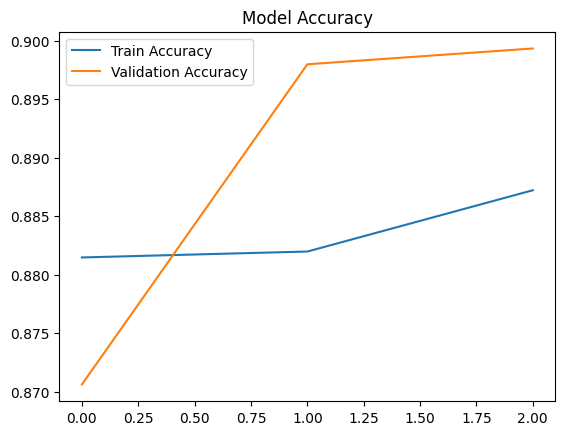

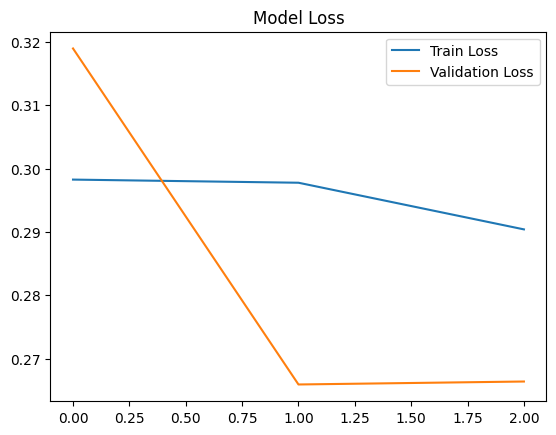

In [13]:
import matplotlib.pyplot as plt

plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.legend()
plt.title('Model Accuracy')
plt.show()

plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend()
plt.title('Model Loss')
plt.show()


In [ ]:
from tensorflow.keras.models import load_model

model = load_model("best_model.keras")


In [37]:
IMG_SIZE = (128, 128)


In [38]:
def preprocess_frame(frame):
    frame = cv2.resize(frame, IMG_SIZE)
    frame = frame.astype("float32") / 255.0
    return frame


In [39]:
def predict_video(model, video_path, frames_per_second=1):
    cap = cv2.VideoCapture(video_path)
    fps = cap.get(cv2.CAP_PROP_FPS)
    step = int(fps / frames_per_second)

    predictions = []
    frame_index = 0

    while True:
        ret, frame = cap.read()
        if not ret:
            break

        if frame_index % step == 0:
            pre = preprocess_frame(frame)
            pre = np.expand_dims(pre, axis=0)
            pred = model.predict(pre, verbose=0)[0][0]
            predictions.append(pred)

        frame_index += 1

    cap.release()

    if len(predictions) == 0:
        return "ERROR: No frames detected"

    avg_pred = np.mean(predictions)

    if avg_pred > 0.5:
        return f"FAKE ({avg_pred:.3f})"
    else:
        return f"REAL ({avg_pred:.3f})"


In [47]:
result = predict_video(model, r"D:\DeepFake_detector\data\fake\02_27__hugging_happy__6GC9HY9J.mp4")
print("Video Prediction:", result)


Video Prediction: FAKE (0.681)


In [ ]:

# def create_efficientnetb7_model(input_shape=(224, 224, 3)):
#     base_model = EfficientNetB7(weights='imagenet', include_top=False, input_shape=input_shape)
#     base_model.trainable = False  # Freeze the base model

#     model = Sequential([
#         base_model,
#         GlobalAveragePooling2D(),
#         Dropout(0.5),
#         Dense(256, activation='relu'),
#         Dropout(0.3),
#         Dense(1, activation='sigmoid')
#     ])
    
#     model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
#     return model


In [14]:
# # Unfreeze some layers of the base model for fine-tuning
# def create_finetuned_efficientnetb7_model(input_shape=(224, 224, 3)):
#     base_model = EfficientNetB7(weights='imagenet', include_top=False, input_shape=input_shape)
#     base_model.trainable = True  # Unfreeze the base model
    
#     # Unfreeze the last few layers for fine-tuning
#     for layer in base_model.layers[-20:]:
#         layer.trainable = True

#     model = Sequential([
#         base_model,
#         GlobalAveragePooling2D(),
#         Dropout(0.4),  # Adjusted dropout
#         Dense(512, activation='relu'),  # Increased layer size
#         Dropout(0.3),
#         Dense(1, activation='sigmoid')
#     ])
    
#     model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4), loss='binary_crossentropy', metrics=['accuracy'])
#     return model

# model = create_finetuned_efficientnetb7_model()

In [15]:
# # Enhanced Data Augmentation
# train_datagen = ImageDataGenerator(
#     rescale=1./255,
#     rotation_range=30,  # Increased rotation
#     width_shift_range=0.3,
#     height_shift_range=0.3,
#     shear_range=0.3,
#     zoom_range=0.3,
#     horizontal_flip=True,
#     fill_mode='nearest'
# )

# val_datagen = ImageDataGenerator(rescale=1./255)

# train_generator = train_datagen.flow(X_train, y_train, batch_size=16)
# val_generator = val_datagen.flow(X_val, y_val, batch_size=16)
# model.summary() # addictional

In [16]:
# # Train the model with fine-tuning
# history = model.fit(
#     train_generator,
#     epochs=20,  # Increased epochs
#     validation_data=val_generator,
#     callbacks=[
#         tf.keras.callbacks.EarlyStopping(patience=5, restore_best_weights=True),
#         tf.keras.callbacks.ModelCheckpoint('efficientnetb7_deepfake_finetuned.keras', save_best_only=True)
#     ]
# )

In [17]:
# # Evaluate the updated model
# val_loss, val_accuracy = model.evaluate(val_generator)
# print(f"Validation Accuracy: {val_accuracy:.2f}")


In [18]:
# # Plot training history
# import matplotlib.pyplot as plt

# plt.plot(history.history['accuracy'], label='Training Accuracy')
# plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
# plt.title('Model Accuracy')
# plt.xlabel('Epoch')
# plt.ylabel('Accuracy')
# plt.legend()
# plt.show()

In [19]:
# def create_finetuned_model(input_shape=(224, 224, 3)):
#     base_model = EfficientNetB7(weights='imagenet', include_top=False, input_shape=input_shape)
#     base_model.trainable = True  # Fine-tune more layers

#     model = Sequential([
#         base_model,
#         GlobalAveragePooling2D(),
#         Dropout(0.5),
#         Dense(512, activation='relu'),
#         Dropout(0.3),
#         Dense(1, activation='sigmoid')
#     ])
    
#     model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-5), loss='binary_crossentropy', metrics=['accuracy'])
#     return model

# model = create_finetuned_model()
# model.summary() # addictional

In [20]:
# # Re-train the model
# history = model.fit(
#     train_generator,
#     epochs=30,
#     validation_data=val_generator,
#     callbacks=[
#         tf.keras.callbacks.EarlyStopping(patience=5, restore_best_weights=True),
#         tf.keras.callbacks.ModelCheckpoint('efficientnetb7_deepfake_finetuned.keras', save_best_only=True)
#     ]
# )


In [21]:
# # Retrieve training and validation accuracy
# train_accuracy = history.history['accuracy']
# val_accuracy = history.history['val_accuracy']


In [22]:
# # Print the final epoch's accuracy
# print(f"Final Training Accuracy: {train_accuracy[-1]:.2f}")
# print(f"Final Validation Accuracy: {val_accuracy[-1]:.2f}")


In [23]:
# # Plot accuracy
# plt.figure(figsize=(12, 4))
# plt.subplot(1, 2, 1)
# plt.plot(train_accuracy, label='Training Accuracy')
# plt.plot(val_accuracy, label='Validation Accuracy')
# plt.title('Model Accuracy')
# plt.xlabel('Epoch')
# plt.ylabel('Accuracy')
# plt.legend()

# # Plot loss
# plt.subplot(1, 2, 2)
# plt.plot(history.history['loss'], label='Training Loss')
# plt.plot(history.history['val_loss'], label='Validation Loss')
# plt.title('Model Loss')
# plt.xlabel('Epoch')
# plt.ylabel('Loss')
# plt.legend()

# plt.tight_layout()
# plt.show()


In [24]:
# def predict_video(video_path, model, num_frames=20):
#     frames = extract_frames(video_path, num_frames=num_frames)
#     frames = frames / 255.0  # Normalize
#     predictions = model.predict(frames)
#     avg_prediction = np.mean(predictions)
    
#     return avg_prediction > 0.5, avg_prediction

In [25]:
# # Test on a sample video
# sample_video_path = '/kaggle/input/deep-fake-detection-dfd-entire-original-dataset/DFD_manipulated_sequences/DFD_manipulated_sequences/01_04__kitchen_still__GBC7ZGDP.mp4'  # Replace with the actual path
# is_manipulated, confidence = predict_video(sample_video_path, model)

# if is_manipulated:
#     print(f"The video is predicted to be a deepfake with {confidence * 100:.2f}% confidence.")
# else:
#     print(f"The video is predicted to be original with {(1 - confidence) * 100:.2f}% confidence.")



In [26]:
# # Save the model in the Keras format
# model.save('deepfake_detector.keras')